# Causal discovery of time series

Tigramite + TCDF tests

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
google_colab = False
mount_google_drive = False

In [3]:
import os
import sys

if google_colab:
    !pip install tigramite ipympl
    !git clone https://github.com/M-Nauta/TCDF.git
    path_tcdf = '/content/TCDF'
    path_datasets = ''
    if mount_google_drive:
        from google.colab import drive
        drive.mount('/content/drive')
else:
    path_project = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
    path_tcdf = path_project + '/src'
    path_datasets = path_project + '/datasets'
    path_tcdf_bash = path_tcdf.replace(' ', '\\ ')
    path_datasets_bash = path_datasets.replace(' ', '\\ ')


sys.path.append(path_tcdf)
# sys.path

In [5]:
query = [f'{path_tcdf_bash}/runTCDF.py',
         f'{path_datasets_bash}/demo_dataset.csv',
         f'{path_datasets_bash}/demo_groundtruth.csv',
         f'{path_tcdf_bash}/evaluate_predictions_TCDF.py']

# !chmod 755 {query[0]}

# additional flags
# --help --cuda --data {query[1]}
!python3 {query[0]} --ground_truth {query[1]}={query[2]} # --plot --epochs=500
# !python3 {query[3]} --data {query[1]}

Arguments: Namespace(cuda=False, data=None, dilation_coefficient=4, epochs=1000, ground_truth={'/Volumes/BPro_HFS/GoogleDrive/Shared drives/Bell Labs Saclay [MukhtarU]/code/TCDF-mod/datasets/demo_dataset.csv': '/Volumes/BPro_HFS/GoogleDrive/Shared drives/Bell Labs Saclay [MukhtarU]/code/TCDF-mod/datasets/demo_groundtruth.csv'}, hidden_layers=0, kernel_size=4, learning_rate=0.01, log_interval=500, optimizer='Adam', plot=False, seed=1111, significance=0.8)

 Dataset:  demo_dataset.csv

 Analysis started for target:  Timeser0
Epoch:  1 [0%] 	Loss: 2.588325
Epoch: 500 [50%] 	Loss: 1.687034
Epoch: 1000 [100%] 	Loss: 1.678622
Potential causes:  [3, 1]
firstloss - realloss = diff
firstloss - testloss = testdiff
2.588324546813965 - 1.678621768951416 = 0.9097027778625488
2.588324546813965 - 1.687770962715149 = 0.9005535840988159
firstloss - realloss = diff
firstloss - testloss = testdiff
2.588324546813965 - 1.678621768951416 = 0.9097027778625488
2.588324546813965 - 1.6947801113128662 = 0.893544

## 1: Time-series generation. Basic example.

Consider a dynamical system, which generates time series coming from a data generating process. 

\begin{align*}
X^0_t &= 0.7 X^0_{t-1} - 0.8 X^1_{t-1} + \eta^0_t\\
X^1_t &= 0.8 X^1_{t-1} + 0.8 X^3_{t-1} + \eta^1_t\\
X^2_t &= 0.5 X^2_{t-1} + 0.5 X^1_{t-2} + 0.6 X^3_{t-3} + \eta^2_t\\
X^3_t &= \eta^3_t\\
\end{align*}

where $\eta$ are independent zero-mean unit variance random variables. Our goal is to reconstruct the drivers of each variable.

In [4]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

import tigramite
import tigramite.data_processing
import tigramite.plotting

sns.set(style='darkgrid')

In [28]:
def generate_ar_process(links_coeffs, time_steps, seed=0):
  np.random.seed(seed)
  return tigramite.data_processing.var_process(links_coeffs, T=time_steps)

def binarize(array, threshold):
  """
  https://stackoverflow.com/questions/33756995/fastest-way-to-filter-values-in-np-array-based-on-changing-threshold
  """
  thresholds = np.full(data.shape, threshold)
  binarized = np.empty(data.shape)

  for slice in range(data.shape[1]):
    binarized[:, slice] = list(map(lambda x: 1 if x == True else 0, (data > thresholds)[:, slice]))
  return binarized


time_steps, num_timeseries = 300, 4 # exactly data.shape

links_coeffs = { 0: [((0, -1), 0.7), ((1, -1), -0.8)],
                 1: [((1, -1), 0.8), ((3, -1), 0.8)],
                 2: [((2, -1), 0.5), ((1, -2), 0.5), ((3, -3), 0.6)],
                 3: [((3, -1), 0.0)],
               }

data, true_parents_neighbors = generate_ar_process(links_coeffs, time_steps)
dataframe = tigramite.data_processing.DataFrame(data)

# Specify time axis and variable names
time_grid = np.arange(time_steps)
var_names = [r'$X^0$', r'$X^1$', r'$X^2$', r'$X^3$']



data_binarized = binarize(data, 0.5)

print(np.shape(data)[0])
print(data)
print(data_binarized)

dataframe_binarized = tigramite.data_processing.DataFrame(data_binarized)

np.savetxt(path_datasets + '/generated/gen_ts.csv', data, header='x0,x1,x2,x3', comments='', delimiter=',')

300
[[ 1.76405235 -1.30652685 -1.55042935 -1.46173269]
 [ 0.40015721  1.65813068  0.41731882 -0.68343977]
 [ 0.97873798 -0.11816405 -0.94436849  0.3675449 ]
 ...
 [-0.41893982  1.69560544 -0.64697868 -0.43243198]
 [-0.57270475  0.78571221  0.6744146   0.57460892]
 [-1.51929131  1.74705904  0.40720952 -0.22295918]]
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 ...
 [0. 1. 0. 0.]
 [0. 1. 1. 1.]
 [0. 1. 0. 0.]]


## TCDF in Jupyter


 Dataset:  gen_ts.csv

 Analysis started for target:  x0
Epoch:  1 [0%] 	Loss: 23.289589
Epoch: 500 [50%] 	Loss: 0.992511
Epoch: 1000 [100%] 	Loss: 0.947057
Potential causes:  [1, 0]
firstloss - realloss = diff
firstloss - testloss = testdiff
23.289588928222656 - 0.947056770324707 = 22.34253215789795
23.289588928222656 - 7.379023551940918 = 15.910565376281738
firstloss - realloss = diff
firstloss - testloss = testdiff
23.289588928222656 - 0.947056770324707 = 22.34253215789795
23.289588928222656 - 20.306373596191406 = 2.98321533203125
Validated causes:  [1, 0]

 Analysis started for target:  x1
Epoch:  1 [0%] 	Loss: 4.762141
Epoch: 500 [50%] 	Loss: 0.752965
Epoch: 1000 [100%] 	Loss: 0.724626
Potential causes:  [1, 0, 3]
firstloss - realloss = diff
firstloss - testloss = testdiff
4.762141227722168 - 0.7246261239051819 = 4.037515103816986
4.762141227722168 - 6.320371627807617 = -1.5582304000854492
firstloss - realloss = diff
firstloss - testloss = testdiff
4.762141227722168 - 0.724626123

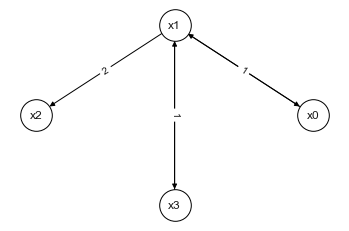

ADDSTCN(
  (dwn): DepthwiseNet(
    (network): Sequential(
      (0): FirstBlock(
        (conv1): Conv1d(4, 4, kernel_size=(4,), stride=(1,), padding=(3,), groups=4)
        (chomp1): Chomp1d()
        (net): Sequential(
          (0): Conv1d(4, 4, kernel_size=(4,), stride=(1,), padding=(3,), groups=4)
          (1): Chomp1d()
        )
        (relu): PReLU(num_parameters=4)
      )
      (1): LastBlock(
        (conv1): Conv1d(4, 4, kernel_size=(4,), stride=(1,), padding=(3,), groups=4)
        (chomp1): Chomp1d()
        (net): Sequential(
          (0): Conv1d(4, 4, kernel_size=(4,), stride=(1,), padding=(3,), groups=4)
          (1): Chomp1d()
        )
        (linear): Linear(in_features=4, out_features=4, bias=True)
      )
    )
  )
  (pointwise): Conv1d(4, 1, kernel_size=(1,), stride=(1,))
)

In [5]:
from TCDF_wrapper import TCDF

dataset = path_datasets + '/generated/gen_ts.csv'
dataset_gt = path_datasets + '/generated/gen_ts_groundtruth_reverse.csv'

TCDF_solver = TCDF(f'{dataset}={dataset_gt}', ground_truth_provided=True, plot=True)
TCDF_solver.solve()

TCDF_solver.model

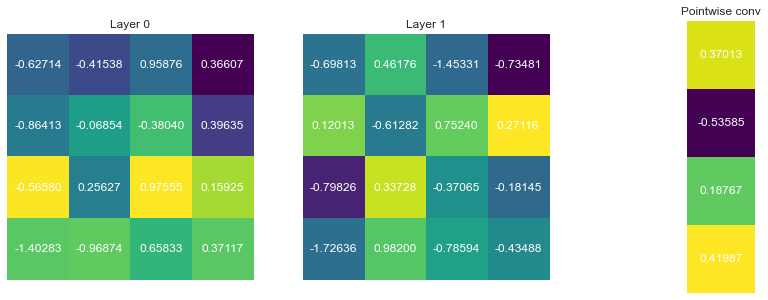

In [106]:
def visualise_weights(model, pointwise=False):
  layer_num = len(model.dwn.network)
  fig, ax = plt.subplots(1, layer_num + int(pointwise), figsize=(5 * (layer_num + int(pointwise)), 5))
  
  for layer in range(layer_num):
    data = model.dwn.network[layer].net[0].weight.data.numpy()[:,0,:]

    ax[layer].axis("off")
    ax[layer].imshow(data.T, cmap='viridis')
    for (i, j), z in np.ndenumerate(data):
        ax[layer].text(j, i, '{:0.5f}'.format(z), ha='center', va='center', color='w')
    ax[layer].set_title(f'Layer {layer}')
  
  if pointwise:
    data = model.pointwise.weight.data.numpy()[0,:,:]

    ax[layer_num].axis("off")
    ax[layer_num].imshow(data, cmap='viridis')
    for (i, j), z in np.ndenumerate(data):
        ax[layer_num].text(j, i, '{:0.5f}'.format(z), ha='center', va='center', color='w')
    ax[layer_num].set_title(f'Pointwise conv')
  return fig

plt.show(visualise_weights(TCDF_solver.model, pointwise=True))

In [12]:
query = [f'{path_tcdf_bash}/runTCDF.py',
         f'{path_datasets_bash}/generated/gen_ts.csv',
         f'{path_datasets_bash}/generated/gen_ts_groundtruth_reverse.csv',
         f'{path_tcdf_bash}/evaluate_predictions_TCDF.py']

!python3 {query[0]} --ground_truth {query[1]}={query[2]} --significance=1.0 --epochs=1000 # --hidden_layers=1 --kernel_size=5 --dilation_coefficient=5 --data

Arguments: Namespace(cuda=False, data=None, dilation_coefficient=4, epochs=1000, ground_truth={'/Volumes/BPro_HFS/GoogleDrive/Shared drives/Bell Labs Saclay [MukhtarU]/code/TCDF-mod/datasets/generated/gen_ts.csv': '/Volumes/BPro_HFS/GoogleDrive/Shared drives/Bell Labs Saclay [MukhtarU]/code/TCDF-mod/datasets/generated/gen_ts_groundtruth_reverse.csv'}, hidden_layers=0, kernel_size=4, learning_rate=0.01, log_interval=500, optimizer='Adam', plot=False, seed=1111, significance=1.0)

 Dataset:  gen_ts.csv

 Analysis started for target:  x0
Epoch:  1 [0%] 	Loss: 22.775690
Epoch: 500 [50%] 	Loss: 1.076327
Epoch: 1000 [100%] 	Loss: 0.965032
Potential causes:  [1, 0]
firstloss - realloss = diff
firstloss - testloss = testdiff
22.77569007873535 - 0.9650322198867798 = 21.810657858848572
22.77569007873535 - 7.597335338592529 = 15.178354740142822
firstloss - realloss = diff
firstloss - testloss = testdiff
22.77569007873535 - 0.9650322198867798 = 21.810657858848572
22.77569007873535 - 20.52859306335

## Other Tigramite functionality test

Could not import sklearn for GPACE
Could not import r-package RCIT
Could not import r-package acepack for GPACE, use python ACE package
Could not import python ACE package for GPACE
Could not import statsmodels, p-value corrections not available.

## Estimating lagged dependencies


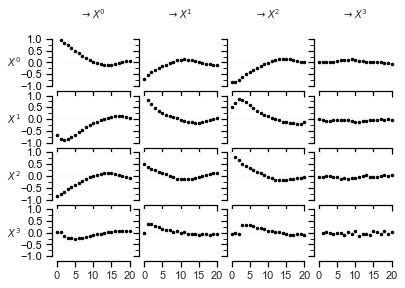

In [46]:
from tigramite.independence_tests import ParCorr
from tigramite.pcmci import PCMCI

parcorr = ParCorr(significance='analytic')

pcmci = PCMCI(dataframe=dataframe,
              cond_ind_test=parcorr,
              verbosity=1)

correlations = pcmci.get_lagged_dependencies(tau_max=20)

lag_func_matrix = tigramite.plotting.plot_lagfuncs(val_matrix=correlations,
                                                   setup_args={'var_names':var_names,
                                                               'x_base':5, 'y_base':.5})

pcmci.verbosity = 0
results = pcmci.run_pcmci(tau_max=8, pc_alpha=None)

plotting time series from first dynamical system


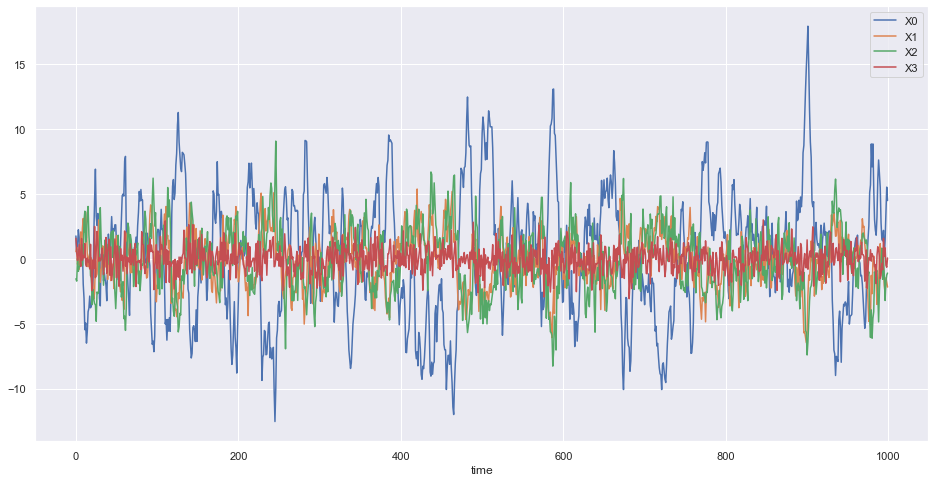

In [14]:
# tigramite.plotting.plot_timeseries(data, time_grid, var_names)

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

print('plotting time series from first dynamical system')
ax.plot(dataframe.values[:,0])
ax.plot(dataframe.values[:,1])
ax.plot(dataframe.values[:,2])
ax.plot(dataframe.values[:,3])
ax.legend(['X0', 'X1', 'X2', 'X3'])

ax.set_xlabel('time')

plt.show()

plotting discrete time series


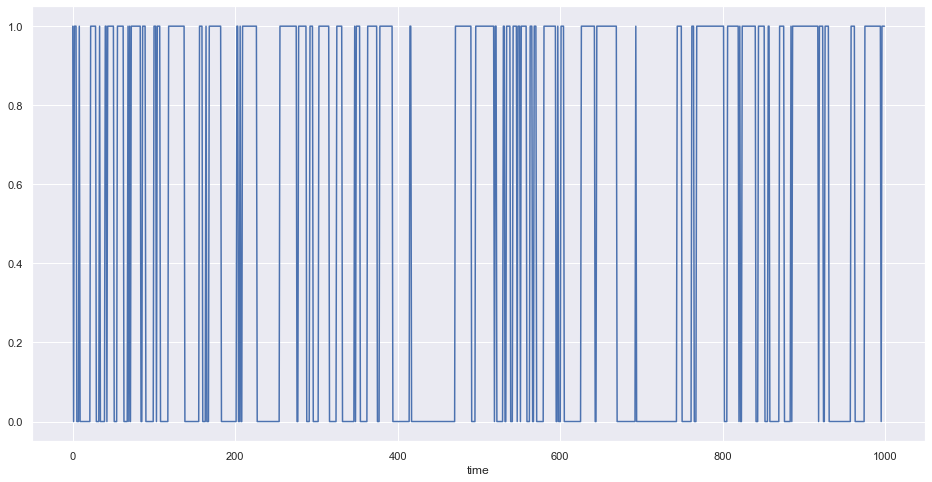

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

print('plotting discrete time series')
ax.plot(dataframe_binarized.values[:, 0])

ax.set_xlabel('time')

plt.show()